# This notebook assess the effect of tuning the Xe gas gain in the $O^2$ simulation on our ML discrimination capability 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import keras 
from keras.models import Sequential
from keras.layers import Dense 
import tensorflow
#from tensorflow.keras.utils import to_categorical
from keras import layers
#from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten
from keras import backend as K
from keras.utils import np_utils

from tensorflow.keras.models import load_model

In [2]:
%ls

 Volume in drive C is Windows
 Volume Serial Number is 4051-E7E7

 Directory of C:\Users\Nikhiel\Desktop\model_analysis

2023/01/19  09:41    <DIR>          .
2023/01/19  09:24    <DIR>          ..
2023/01/19  09:33    <DIR>          .ipynb_checkpoints
2022/12/13  08:10    <DIR>          __pycache__
2022/11/28  10:04         1ÿ459ÿ166 Analysis_of_nets(1)_updated.html
2022/11/28  21:35           800ÿ771 Analysis_of_nets.ipynb
2022/11/28  02:11           161ÿ352 ann1.h5
2022/11/06  00:42             2ÿ899 avgph.py
2022/12/14  10:42           758ÿ157 Clean_simsigs_eap20.csv
2022/12/14  11:02           851ÿ214 Clean_simsigs_eap40.csv
2022/12/14  11:33           876ÿ566 Clean_simsigs_eap80.csv
2022/12/11  13:24            54ÿ422 Clean_xe1000.csv
2022/12/13  13:46           248ÿ472 Clean_xe1400.csv
2022/12/11  13:24           469ÿ330 Clean_xe2000.csv
2022/12/13  13:47           620ÿ215 Clean_xe2400.csv
2022/12/13  13:47           576ÿ557 Clean_xe2700.csv
2022/12/11  13:25           648ÿ229 C

## Load in our test data and extract the real signals 

In [3]:
testset = pd.read_csv('test.csv')

In [4]:
testset.head()

,AN00,AN01,AN02,AN03,AN04,AN05,AN06,AN07,AN08,AN09,...,BN21,BN22,BN23,BN24,BN25,BN26,BN27,BN28,BN29,label
0,10,8,10,11,10,10,20,63,68,42,...,15,15,14,13,13,13,12,12,12,0
1,89,122,65,40,30,26,23,22,19,18,...,14,13,11,11,12,11,14,11,11,0
2,11,12,10,13,12,13,12,12,14,15,...,10,11,9,11,8,9,13,10,10,0
3,30,46,29,22,19,20,38,50,39,37,...,11,9,8,11,9,7,10,9,9,0
4,16,20,16,15,12,12,12,11,11,11,...,31,29,25,28,37,34,30,25,32,1


In [5]:
testset.shape[0]

80268

## Now filter the testset and retain only the real signals ie. label = 0 

(array([60134.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 20134.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

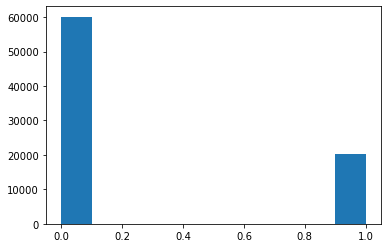

In [6]:
plt.hist(testset.label)

There are 60134 real signals 

In [7]:
real_test = testset[testset.label==0]

In [8]:
real_test.shape

(60134, 91)

This matches our number so we have retained all the real signals 

In [9]:
real_test.head()

,AN00,AN01,AN02,AN03,AN04,AN05,AN06,AN07,AN08,AN09,...,BN21,BN22,BN23,BN24,BN25,BN26,BN27,BN28,BN29,label
0,10,8,10,11,10,10,20,63,68,42,...,15,15,14,13,13,13,12,12,12,0
1,89,122,65,40,30,26,23,22,19,18,...,14,13,11,11,12,11,14,11,11,0
2,11,12,10,13,12,13,12,12,14,15,...,10,11,9,11,8,9,13,10,10,0
3,30,46,29,22,19,20,38,50,39,37,...,11,9,8,11,9,7,10,9,9,0
5,16,10,12,10,10,14,11,7,10,9,...,101,80,67,52,45,34,44,61,62,0


## Read in our tuned sim data 

In [10]:
%ls

 Volume in drive C is Windows
 Volume Serial Number is 4051-E7E7

 Directory of C:\Users\Nikhiel\Desktop\model_analysis

2023/01/19  09:41    <DIR>          .
2023/01/19  09:24    <DIR>          ..
2023/01/19  09:33    <DIR>          .ipynb_checkpoints
2022/12/13  08:10    <DIR>          __pycache__
2022/11/28  10:04         1ÿ459ÿ166 Analysis_of_nets(1)_updated.html
2022/11/28  21:35           800ÿ771 Analysis_of_nets.ipynb
2022/11/28  02:11           161ÿ352 ann1.h5
2022/11/06  00:42             2ÿ899 avgph.py
2022/12/14  10:42           758ÿ157 Clean_simsigs_eap20.csv
2022/12/14  11:02           851ÿ214 Clean_simsigs_eap40.csv
2022/12/14  11:33           876ÿ566 Clean_simsigs_eap80.csv
2022/12/11  13:24            54ÿ422 Clean_xe1000.csv
2022/12/13  13:46           248ÿ472 Clean_xe1400.csv
2022/12/11  13:24           469ÿ330 Clean_xe2000.csv
2022/12/13  13:47           620ÿ215 Clean_xe2400.csv
2022/12/13  13:47           576ÿ557 Clean_xe2700.csv
2022/12/11  13:25           648ÿ229 C

In [11]:
# retain only the first 90 columns which contain the adc values for each pad column and time bin 

df1000 = pd.read_csv('Clean_xe1000.csv').iloc[:, :90]
df2000 = pd.read_csv('Clean_xe2000.csv').iloc[:, :90]
df3000 = pd.read_csv('Clean_xe3000.csv').iloc[:, :90]
df3200 = pd.read_csv('Clean_xe3200.csv').iloc[:, :90]
df3600 = pd.read_csv('Clean_xe3600.csv').iloc[:, :90]
df4000 = pd.read_csv('Clean_xe4000.csv').iloc[:, :90]


df1400 = pd.read_csv('Clean_xe1400.csv').iloc[:, :90]
df2400 = pd.read_csv('Clean_xe2400.csv').iloc[:, :90]
df2700 = pd.read_csv('Clean_xe2700.csv').iloc[:, :90]
df3100 = pd.read_csv('Clean_xe3100.csv').iloc[:, :90]
df3400 = pd.read_csv('Clean_xe3400.csv').iloc[:, :90]




In [12]:
## Create a label column set to 1 to denote that these are sim signals 

df1000['label'] = 1
df2000['label'] = 1
df3000['label'] = 1
df3200['label'] = 1
df3600['label'] = 1
df4000['label'] = 1

df1400['label'] = 1
df2400['label'] = 1
df2700['label'] = 1
df3100['label'] = 1
df3400['label'] = 1


## Now combine each of these tuned data with our real test data to form a new test set of real signals and tuned sim signals according to a certain gas gain 

In [13]:
df1000

,AN00,AN01,AN02,AN03,AN04,AN05,AN06,AN07,AN08,AN09,...,BN21,BN22,BN23,BN24,BN25,BN26,BN27,BN28,BN29,label
0,11,10,13,10,11,12,12,17,27,43,...,14,13,13,12,11,12,13,11,12,1
1,11,9,16,16,16,20,18,22,26,27,...,11,10,9,9,9,9,11,11,10,1
2,17,33,30,21,20,15,16,18,14,12,...,21,18,15,16,14,13,15,16,11,1
3,10,12,13,12,13,16,14,11,14,12,...,18,17,14,13,14,12,12,13,14,1
4,10,16,16,10,12,11,12,9,10,11,...,20,19,17,16,14,15,13,11,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,12,17,16,15,13,16,13,11,14,13,...,26,26,22,19,16,15,16,15,16,1
131,27,45,42,38,32,35,34,28,24,20,...,7,10,10,9,10,11,11,10,10,1
132,10,11,10,10,11,12,13,17,23,25,...,30,27,24,20,17,15,15,14,12,1
133,21,34,30,26,22,18,17,16,19,16,...,20,18,17,14,16,14,15,16,16,1


In [14]:
df1000.shape

(135, 91)

In [15]:
# Now join each tuned set to our real test set to create a new test set based on the new tuned sim signals 

test1000 = real_test.append(df1000, ignore_index=True)
test2000 = real_test.append(df2000, ignore_index=True)
test3000 = real_test.append(df3000, ignore_index=True)
test3200 = real_test.append(df3200, ignore_index=True)
test3600 = real_test.append(df3600, ignore_index=True)
test4000 = real_test.append(df4000, ignore_index=True)

test1400 = real_test.append(df1400, ignore_index=True)
test2400 = real_test.append(df2400, ignore_index=True)
test2700 = real_test.append(df2700, ignore_index=True)

test3100 = real_test.append(df3100, ignore_index=True)
test3400 = real_test.append(df3400, ignore_index=True)



### Now from these new test sets we will perform furhter preparation for ML prediction 

In [16]:
sig_1000 = np.array(test1000.iloc[:, :90]).reshape(len(test1000), 3, 30)
sig_2000 = np.array(test2000.iloc[:, :90]).reshape(len(test2000), 3, 30)
sig_3000 = np.array(test3000.iloc[:, :90]).reshape(len(test3000), 3, 30)
sig_3200 = np.array(test3200.iloc[:, :90]).reshape(len(test3200), 3, 30)
sig_3600 = np.array(test3600.iloc[:, :90]).reshape(len(test3600), 3, 30)
sig_4000 = np.array(test4000.iloc[:, :90]).reshape(len(test4000), 3, 30)



sig_1400 = np.array(test1400.iloc[:, :90]).reshape(len(test1400), 3, 30)
sig_2400 = np.array(test2400.iloc[:, :90]).reshape(len(test2400), 3, 30)
sig_2700 = np.array(test2700.iloc[:, :90]).reshape(len(test2700), 3, 30)
sig_3100 = np.array(test3100.iloc[:, :90]).reshape(len(test3100), 3, 30)
sig_3400 = np.array(test3400.iloc[:, :90]).reshape(len(test3400), 3, 30)




In [17]:

### We're not doing any normalization since we're using our unormed cnn models 
#--------------------------------------------------------------------------
#==========================================================================

# We remove division by the max adc value 

sig_1000_n = sig_1000
sig_2000_n = sig_2000
sig_3000_n = sig_3000
sig_3200_n = sig_3200
sig_3600_n = sig_3600
sig_4000_n = sig_4000



sig_1400_n = sig_1400
sig_2400_n = sig_2400
sig_2700_n = sig_2700
sig_3100_n = sig_3100
sig_3400_n = sig_3400

In [18]:
# Now get the corresponding labels 

lab1000 = np.array(test1000.label)
lab2000 = np.array(test2000.label)
lab3000 = np.array(test3000.label)
lab3200 = np.array(test3200.label)
lab3600 = np.array(test3600.label)
lab4000 = np.array(test4000.label)

lab1400 = np.array(test1400.label)
lab2400 = np.array(test2400.label)
lab2700 = np.array(test2700.label)
lab3100 = np.array(test3100.label)
lab3400 = np.array(test3400.label)



In [19]:
# Now one hot encode them 
lab1000_ohe = keras.utils.np_utils.to_categorical(lab1000, 2)
lab2000_ohe = keras.utils.np_utils.to_categorical(lab2000, 2)
lab3000_ohe = keras.utils.np_utils.to_categorical(lab3000, 2)
lab3200_ohe = keras.utils.np_utils.to_categorical(lab3200, 2)
lab3600_ohe = keras.utils.np_utils.to_categorical(lab3600, 2)
lab4000_ohe = keras.utils.np_utils.to_categorical(lab4000, 2)


lab1400_ohe = keras.utils.np_utils.to_categorical(lab1400, 2)
lab2400_ohe = keras.utils.np_utils.to_categorical(lab2400, 2)
lab2700_ohe = keras.utils.np_utils.to_categorical(lab2700, 2)
lab3100_ohe = keras.utils.np_utils.to_categorical(lab3100, 2)
lab3400_ohe = keras.utils.np_utils.to_categorical(lab3400, 2)






# Load the best keras CNN model we have trained so far 

In [20]:
cnn2 = load_model('unorm_cnn_NET1.h5')

In [21]:
cnn2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convol2D (Conv2D)           (None, 3, 30, 120)        1200      
                                                                 
 maxpool (MaxPooling2D)      (None, 1, 10, 120)        0         
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dropout (Dropout)           (None, 1200)              0         
                                                                 
 Dense-output (Dense)        (None, 2)                 2402      
                                                                 
Total params: 3,602
Trainable params: 3,602
Non-trainable params: 0
_________________________________________________________________


## Perform some filter visualization later here ...

# Now predict on the various test data 

In [22]:
prob1000_cnn2 = cnn2.predict(sig_1000_n)
prob2000_cnn2 = cnn2.predict(sig_2000_n)
prob3000_cnn2 = cnn2.predict(sig_3000_n)
prob3200_cnn2 = cnn2.predict(sig_3200_n)
prob3600_cnn2 = cnn2.predict(sig_3600_n)
prob4000_cnn2 = cnn2.predict(sig_4000_n)


prob1400_cnn2 = cnn2.predict(sig_1400_n)
prob2400_cnn2 = cnn2.predict(sig_2400_n)
prob2700_cnn2 = cnn2.predict(sig_2700_n)
prob3100_cnn2 = cnn2.predict(sig_3100_n)
prob3400_cnn2 = cnn2.predict(sig_3400_n)



In [23]:
pred1000_cnn2 = np.argmax(prob1000_cnn2, axis=1)
pred2000_cnn2 = np.argmax(prob2000_cnn2, axis=1)
pred3000_cnn2 = np.argmax(prob3000_cnn2, axis=1)
pred3200_cnn2 = np.argmax(prob3200_cnn2, axis=1)
pred3600_cnn2 = np.argmax(prob3600_cnn2, axis=1)
pred4000_cnn2 = np.argmax(prob4000_cnn2, axis=1)


pred1400_cnn2 = np.argmax(prob1400_cnn2, axis=1)
pred2400_cnn2 = np.argmax(prob2400_cnn2, axis=1)
pred2700_cnn2 = np.argmax(prob2700_cnn2, axis=1)
pred3100_cnn2 = np.argmax(prob3100_cnn2, axis=1)
pred3400_cnn2 = np.argmax(prob3400_cnn2, axis=1)

In [24]:
from sklearn import metrics

# Now get the performance metrics 

In [25]:
Prec_1000 = metrics.precision_score(lab1000, pred1000_cnn2, pos_label=1)
rec_1000 = metrics.recall_score(lab1000, pred1000_cnn2, pos_label=1)
Spec_1000 = metrics.recall_score(lab1000, pred1000_cnn2, pos_label=1)
F1_1000 = metrics.f1_score(lab1000, pred1000_cnn2, pos_label=1)
Acc_1000 = metrics.accuracy_score(lab1000, pred1000_cnn2)

In [26]:
Prec_2000 = metrics.precision_score(lab2000, pred2000_cnn2, pos_label=1)
rec_2000 = metrics.recall_score(lab2000, pred2000_cnn2, pos_label=1)
Spec_2000 = metrics.recall_score(lab2000, pred2000_cnn2, pos_label=1)
F1_2000 = metrics.f1_score(lab2000, pred2000_cnn2, pos_label=1)
Acc_2000 = metrics.accuracy_score(lab2000, pred2000_cnn2)

In [27]:
Prec_3000 = metrics.precision_score(lab3000, pred3000_cnn2, pos_label=1)
rec_3000 = metrics.recall_score(lab3000, pred3000_cnn2, pos_label=1)
Spec_3000 = metrics.recall_score(lab3000, pred3000_cnn2, pos_label=1)
F1_3000 = metrics.f1_score(lab3000, pred3000_cnn2, pos_label=1)
Acc_3000 = metrics.accuracy_score(lab3000, pred3000_cnn2)

In [28]:
Prec_3200 = metrics.precision_score(lab3200, pred3200_cnn2, pos_label=1)
rec_3200 = metrics.recall_score(lab3200, pred3200_cnn2, pos_label=1)
Spec_3200 = metrics.recall_score(lab3200, pred3200_cnn2, pos_label=1)
F1_3200 = metrics.f1_score(lab3200, pred3200_cnn2, pos_label=1)
Acc_3200 = metrics.accuracy_score(lab3200, pred3200_cnn2)

In [29]:
Prec_3600 = metrics.precision_score(lab3600, pred3600_cnn2, pos_label=1)
rec_3600 = metrics.recall_score(lab3600, pred3600_cnn2, pos_label=1)
Spec_3600 = metrics.recall_score(lab3600, pred3600_cnn2, pos_label=1)
F1_3600 = metrics.f1_score(lab3600, pred3600_cnn2, pos_label=1)
Acc_3600 = metrics.accuracy_score(lab3600, pred3600_cnn2)

In [30]:
Prec_4000 = metrics.precision_score(lab4000, pred4000_cnn2, pos_label=1)
rec_4000 = metrics.recall_score(lab4000, pred4000_cnn2, pos_label=1)
Spec_4000 = metrics.recall_score(lab4000, pred4000_cnn2, pos_label=1)
F1_4000 = metrics.f1_score(lab4000, pred4000_cnn2, pos_label=1)
Acc_4000 = metrics.accuracy_score(lab4000, pred4000_cnn2)

In [31]:
Prec_1400 = metrics.precision_score(lab1400, pred1400_cnn2, pos_label=1)
rec_1400 = metrics.recall_score(lab1400, pred1400_cnn2, pos_label=1)
Spec_1400 = metrics.recall_score(lab1400, pred1400_cnn2, pos_label=1)
F1_1400 = metrics.f1_score(lab1400, pred1400_cnn2, pos_label=1)
Acc_1400 = metrics.accuracy_score(lab1400, pred1400_cnn2)

In [32]:
Prec_2400 = metrics.precision_score(lab2400, pred2400_cnn2, pos_label=1)
rec_2400 = metrics.recall_score(lab2400, pred2400_cnn2, pos_label=1)
Spec_2400 = metrics.recall_score(lab2400, pred2400_cnn2, pos_label=1)
F1_2400 = metrics.f1_score(lab2400, pred2400_cnn2, pos_label=1)
Acc_2400 = metrics.accuracy_score(lab2400, pred2400_cnn2)

In [33]:
Prec_2700 = metrics.precision_score(lab2700, pred2700_cnn2, pos_label=1)
rec_2700 = metrics.recall_score(lab2700, pred2700_cnn2, pos_label=1)
Spec_2700 = metrics.recall_score(lab2700, pred2700_cnn2, pos_label=1)
F1_2700 = metrics.f1_score(lab2700, pred2700_cnn2, pos_label=1)
Acc_2700 = metrics.accuracy_score(lab2700, pred2700_cnn2)

In [34]:
Prec_3100 = metrics.precision_score(lab3100, pred3100_cnn2, pos_label=1)
rec_3100 = metrics.recall_score(lab3100, pred3100_cnn2, pos_label=1)
Spec_3100 = metrics.recall_score(lab3100, pred3100_cnn2, pos_label=1)
F1_3100 = metrics.f1_score(lab3100, pred3100_cnn2, pos_label=1)
Acc_3100 = metrics.accuracy_score(lab3100, pred3100_cnn2)

In [35]:
Prec_3400 = metrics.precision_score(lab3400, pred3400_cnn2, pos_label=1)
rec_3400 = metrics.recall_score(lab3400, pred3400_cnn2, pos_label=1)
Spec_3400 = metrics.recall_score(lab3400, pred3400_cnn2, pos_label=1)
F1_3400 = metrics.f1_score(lab3400, pred3400_cnn2, pos_label=1)
Acc_3400 = metrics.accuracy_score(lab3400, pred3400_cnn2)

In [36]:
metrics_cnn2 = pd.DataFrame({'Precision':[Prec_1000,Prec_1400 ,Prec_2000, Prec_2400, Prec_2700 ,Prec_3000, Prec_3100 ,Prec_3200,Prec_3400 ,Prec_3600, Prec_4000],
                            'Recall':[rec_1000, rec_1400, rec_2000, rec_2400, rec_2700,rec_3000, rec_3100, rec_3200, rec_3400, rec_3600, rec_4000],
                            'Specificity':[Spec_1000,Spec_1400 ,Spec_2000, Spec_2400, Spec_2700,Spec_3000, Spec_3100,Spec_3200,Spec_3400 ,Spec_3600, Spec_4000],
                            'F1':[F1_1000, F1_1400,F1_2000, F1_2400, F1_2700, F1_3000, F1_3100,F1_3200, F1_3400, F1_3600, F1_4000],
                            'Accuracy':[Acc_1000, Acc_1400, Acc_2000, Acc_2400 , Acc_2700 ,Acc_3000, Acc_3100,Acc_3200, Acc_3400 ,Acc_3600, Acc_4000],
                            'Gain':[1000, 1400,2000,2400,2700,3000, 3100,3200,3400, 3600, 4000]})

In [37]:
metrics_cnn2

,Precision,Recall,Specificity,F1,Accuracy,Gain
0,0.081551,0.903704,0.903704,0.149601,0.976987,1000
1,0.285863,0.885668,0.885668,0.432220,0.976216,1400
2,0.442144,0.933962,0.933962,0.600165,0.976330,2000
3,0.515002,0.951729,0.951729,0.668346,0.976519,2400
4,0.499636,0.964160,0.964160,0.658191,0.976851,2700
5,0.530096,0.968145,0.968145,0.685083,0.976917,3000
6,0.584266,0.970840,0.970840,0.729505,0.976949,3100
7,0.547878,0.970845,0.970845,0.700463,0.976976,3200
8,0.550980,0.968409,0.968409,0.702354,0.976905,3400
9,0.606867,0.971599,0.971599,0.747094,0.976957,3600


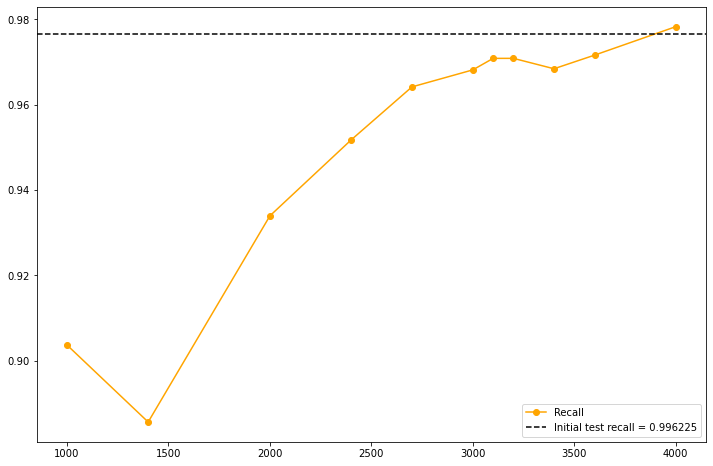

In [77]:
plt.figure(figsize=(12, 8))
#plt.plot(metrics_cnn2['Gain'], metrics_cnn2['Accuracy'], color='steelblue', marker='o')
#plt.plot(metrics_cnn2['Gain'], metrics_cnn2['Precision'], color='red', marker='o', label='precision')
plt.plot(metrics_cnn2['Gain'], metrics_cnn2['Recall'], color='orange', marker='o', label='Recall')
plt.axhline(y=0.97665, linestyle='--', color='black', label='Initial test recall = 0.996225')
#plt.plot(metrics_cnn2['Gain'], metrics_cnn2['Specificity'], color='deeppink', marker='o', label='specificity')
#plt.plot(metrics_cnn2['Gain'], metrics_cnn2['F1'], color='cyan', marker='o', label='F1')
#plt.xlim(2600, 4000)
#plt.ylim(0.98, 1)
plt.legend()
plt.show()

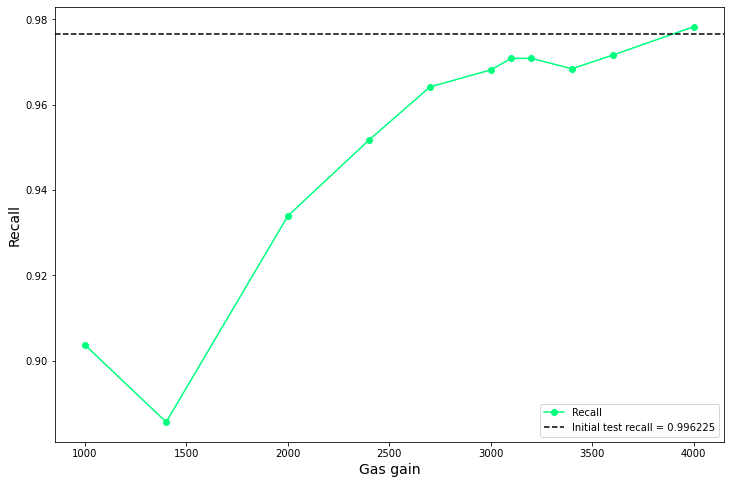

In [76]:
plt.figure(figsize=(12, 8))
#plt.plot(metrics_cnn2['Gain'], metrics_cnn2['Accuracy'], color='steelblue', marker='o')
#plt.plot(metrics_cnn2['Gain'], metrics_cnn2['Precision'], color='red', marker='o', label='precision')
plt.plot(metrics_cnn2['Gain'], metrics_cnn2['Recall'], color='springgreen', marker='o', label='Recall')
plt.axhline(y=0.97665, linestyle='--', color='black', label='Initial test recall = 0.996225')
#plt.plot(metrics_cnn2['Gain'], metrics_cnn2['Specificity'], color='deeppink', marker='o', label='specificity')
#plt.plot(metrics_cnn2['Gain'], metrics_cnn2['F1'], color='cyan', marker='o', label='F1')
#plt.xlim(2600, 4000)
#plt.ylim(0.98, 1)
plt.ylabel("Recall", fontsize=14)
plt.xlabel("Gas gain", fontsize=14)
plt.legend()
plt.show()

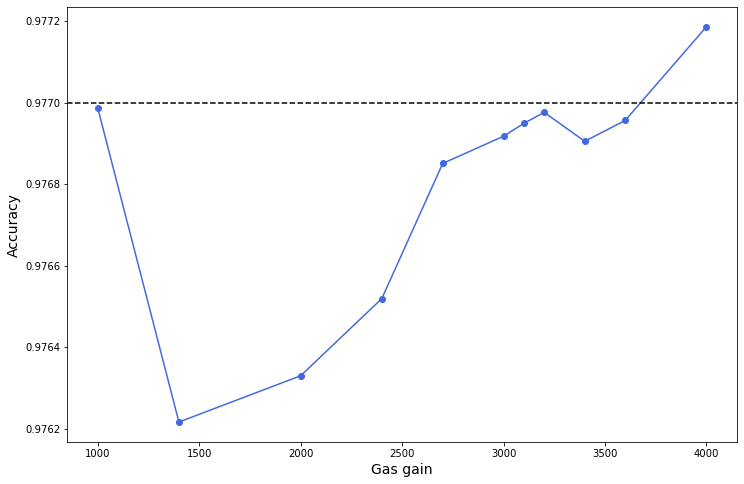

In [80]:
plt.figure(figsize=(12, 8))
plt.plot(metrics_cnn2['Gain'], metrics_cnn2['Accuracy'], color='royalblue', marker='o')
plt.axhline(y=0.9770, linestyle='--', color='black', label="Untuned test accuracy")
plt.xlabel("Gas gain",fontsize=14)
plt.ylabel("Accuracy",fontsize=14)
plt.show()

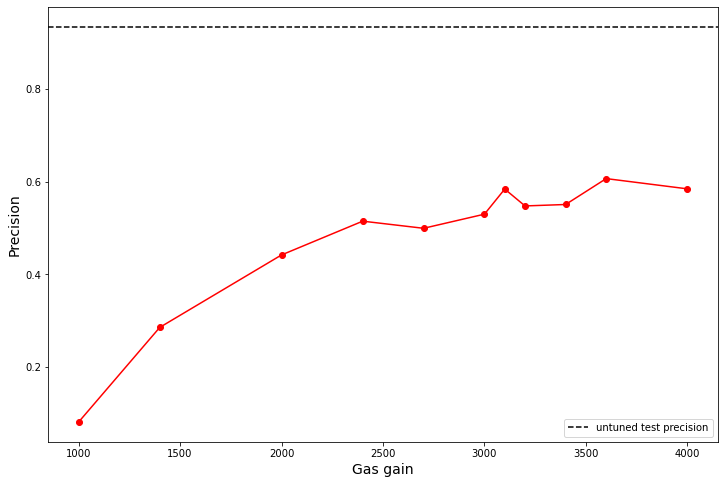

In [74]:
plt.figure(figsize=(12, 8))
#plt.plot(metrics_cnn2['Gain'], metrics_cnn2['Recall'], color='steelblue', marker='o')
plt.plot(metrics_cnn2['Gain'], metrics_cnn2['Precision'], color='red', marker='o')
plt.axhline(y=0.934689, color='black', linestyle='--', label='untuned test precision')
plt.ylabel("Precision",fontsize=14)
plt.xlabel("Gas gain",fontsize=14)
plt.legend()
plt.show()

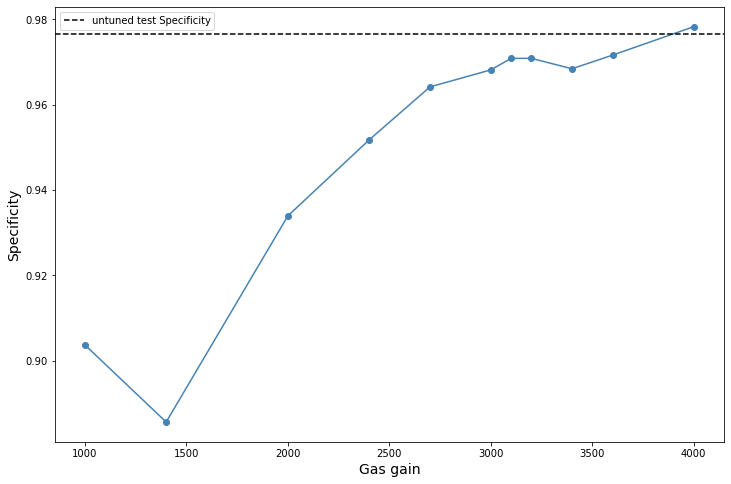

In [82]:
plt.figure(figsize=(12, 8))
#plt.plot(metrics_cnn2['Gain'], metrics_cnn2['Recall'], color='steelblue', marker='o')
plt.plot(metrics_cnn2['Gain'], metrics_cnn2['Specificity'], color='steelblue', marker='o')
plt.axhline(y=0.9766, color='black', linestyle='--', label='untuned test Specificity')
plt.ylabel("Specificity",fontsize=14)
plt.xlabel("Gas gain",fontsize=14)
#plt.xlim(2400, 4000)
#plt.ylim(0.45, 0.681)
plt.legend()
plt.show()

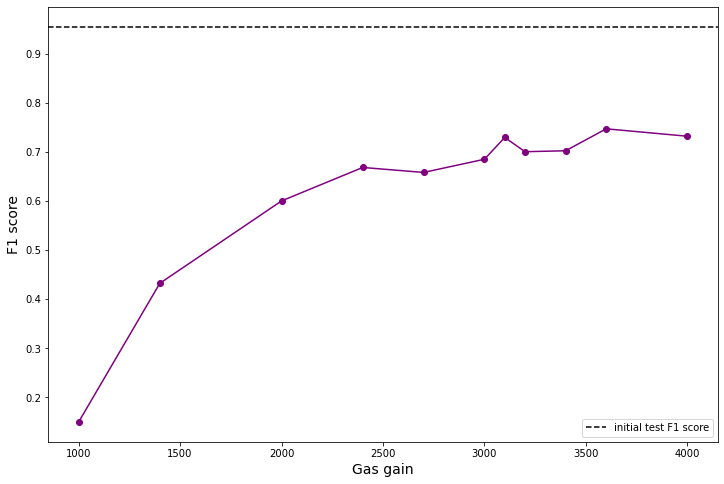

In [78]:
plt.figure(figsize=(12, 8))
#plt.plot(metrics_cnn2['Gain'], metrics_cnn2['Recall'], color='steelblue', marker='o')
plt.plot(metrics_cnn2['Gain'], metrics_cnn2['F1'], color='purple', marker='o')
plt.axhline(y=0.95521, color='black', linestyle='--', label="initial test F1 score")
plt.ylabel("F1 score",fontsize=14)
plt.xlabel("Gas gain",fontsize=14)
plt.legend()
plt.show()

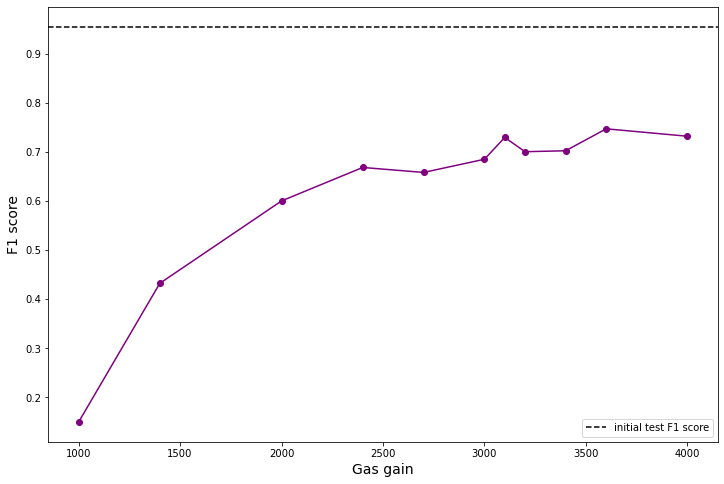

In [79]:
plt.figure(figsize=(12, 8))
#plt.plot(metrics_cnn2['Gain'], metrics_cnn2['Recall'], color='steelblue', marker='o')
plt.plot(metrics_cnn2['Gain'], metrics_cnn2['F1'], color='purple', marker='o')
plt.axhline(y=0.95521, color='black', linestyle='--', label="initial test F1 score")
plt.ylabel("F1 score",fontsize=14)
plt.xlabel("Gas gain",fontsize=14)
#plt.xlim(2400, 4000)
#plt.ylim(0.7, 1)
plt.legend()
plt.show()

In [45]:
from avgph import *

In [46]:
t1000, adc1000 = pharray(df1000)

t1400, adc1400 = pharray(df1400)

t2000, adc2000 = pharray(df2000)

t2400, adc2400 = pharray(df2400)

t2700, adc2700 = pharray(df2700)

t3000, adc3000 = pharray(df3000)

t3100, adc3100 = pharray(df3100)

t3200, adc3200 = pharray(df3200)

t3400, adc3400 = pharray(df3400)

t3600, adc3600 = pharray(df3600)
t4000, adc4000 = pharray(df4000)

In [47]:
tr, adcr = pharray(real_test)

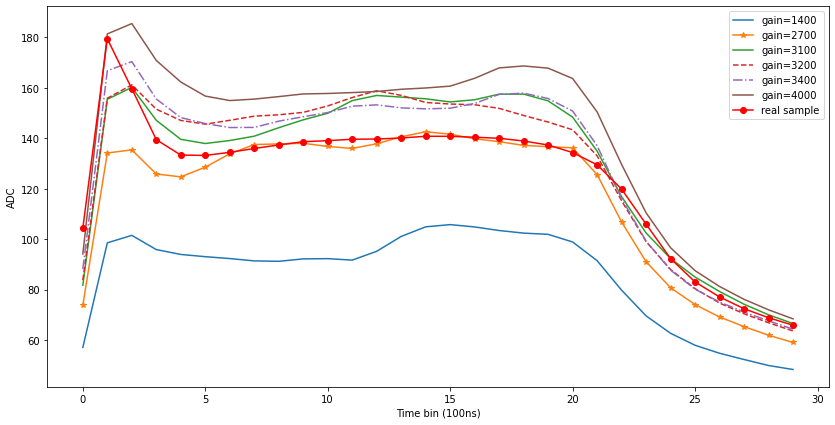

In [48]:
plt.figure(figsize=(14, 7))
#plt.plot(t1000, adc1000, label='gain=1000', linestyle='--')
plt.plot(t1400, adc1400, label='gain=1400', linestyle='-')

#plt.plot(t2000, adc2000, label='gain=2000', linestyle='--')
#plt.plot(t2400, adc2400, label='gain=2400', linestyle='-.')
plt.plot(t2700, adc2700, label='gain=2700', linestyle='-', marker='*')

#plt.plot(t3000, adc3000, label='gain=3000', linestyle='-.')
plt.plot(t3100, adc3100, label='gain=3100', linestyle='-')

plt.plot(t3200, adc3200, label='gain=3200', linestyle='--')
plt.plot(t3400, adc3400, label='gain=3400', linestyle='-.')

#plt.plot(t3600, adc3600, label='gain=3600', linestyle='--')
plt.plot(t4000, adc4000, label='gain=4000', linestyle='-')
plt.plot(tr, adcr, label='real sample', marker='o', color='red')
plt.xlabel("Time bin (100ns)")
plt.ylabel("ADC")
plt.legend()
plt.show()

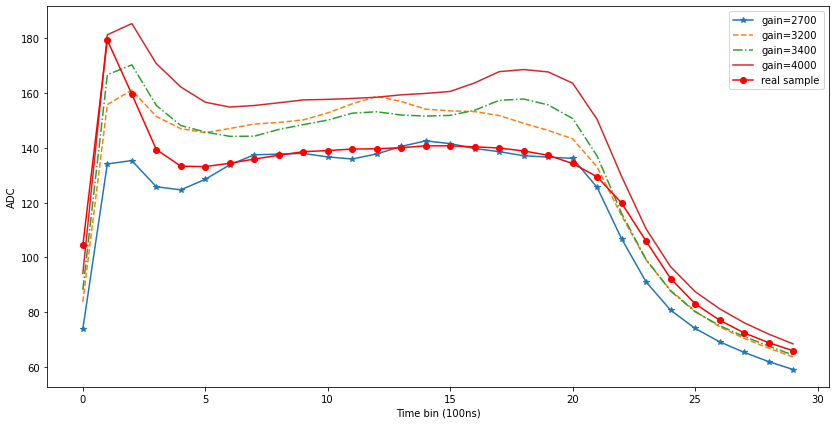

In [49]:
plt.figure(figsize=(14, 7))
#plt.plot(t1000, adc1000, label='gain=1000', linestyle='--')
#plt.plot(t1400, adc1400, label='gain=1400', linestyle='-')

#plt.plot(t2000, adc2000, label='gain=2000', linestyle='--')
#plt.plot(t2400, adc2400, label='gain=2400', linestyle='-.')
plt.plot(t2700, adc2700, label='gain=2700', linestyle='-', marker='*')

#plt.plot(t3000, adc3000, label='gain=3000', linestyle='-.')
#plt.plot(t3100, adc3100, label='gain=3100', linestyle='-')

plt.plot(t3200, adc3200, label='gain=3200', linestyle='--')
plt.plot(t3400, adc3400, label='gain=3400', linestyle='-.')

#plt.plot(t3600, adc3600, label='gain=3600', linestyle='--')
plt.plot(t4000, adc4000, label='gain=4000', linestyle='-')
plt.plot(tr, adcr, label='real sample', marker='o', color='red')
plt.xlabel("Time bin (100ns)")
plt.ylabel("ADC")
plt.legend()
plt.show()

# Confusion matrices

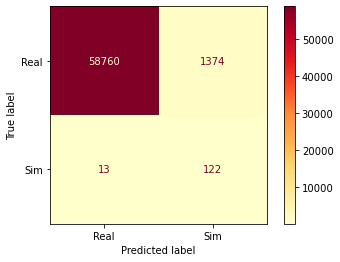

In [50]:
confusion_mat_1000 = metrics.confusion_matrix(lab1000, pred1000_cnn2, labels=[0, 1])
cm_display_1000 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat_1000, display_labels = ["Real", "Sim"])

cm_display_1000.plot(cmap='YlOrRd')
plt.show()

In [51]:
102/(102+805)

0.11245865490628446

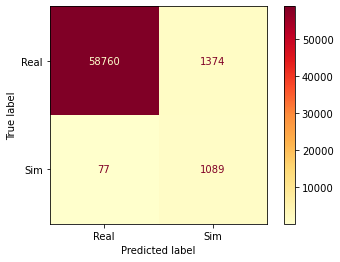

In [52]:
confusion_mat_2000 = metrics.confusion_matrix(lab2000, pred2000_cnn2, labels=[0, 1])
cm_display_2000 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat_2000, display_labels = ["Real", "Sim"])

cm_display_2000.plot(cmap='YlOrRd')
plt.show()

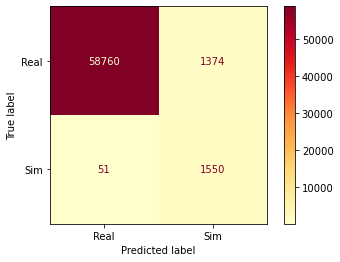

In [53]:
confusion_mat_3000 = metrics.confusion_matrix(lab3000, pred3000_cnn2, labels=[0, 1])
cm_display_3000 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat_3000, display_labels = ["Real", "Sim"])

cm_display_3000.plot(cmap='YlOrRd')
plt.show()

In [54]:
import seaborn as sns 

<AxesSubplot:>

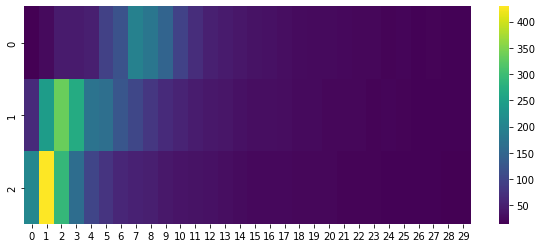

In [55]:
plt.figure(figsize=(10,4))
sns.heatmap(sig_1000_n[10], cmap='viridis')

In [56]:
fout = cnn2.layers[0].output
fin = cnn2.layers[0].input

flmod = Model(inputs = fin, outputs=fout)
act = flmod.predict(sig_1000_n)

In [57]:
act[0][0].shape

(30, 120)

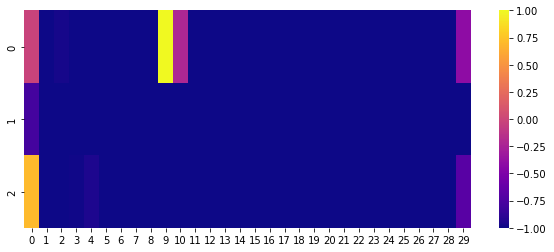

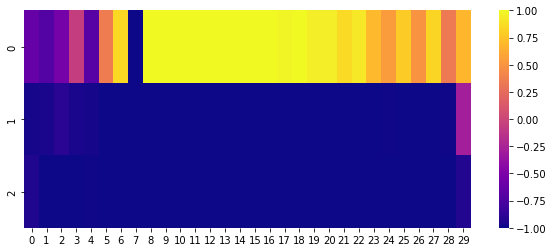

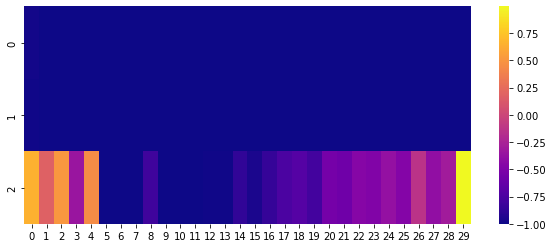

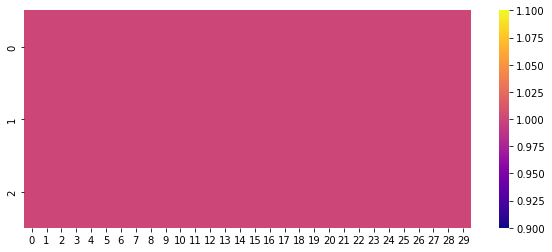

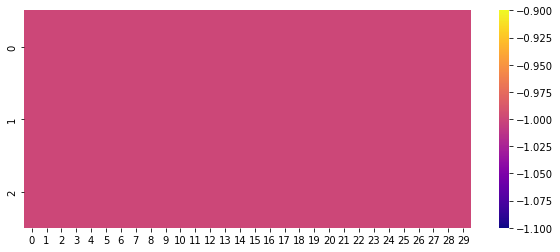

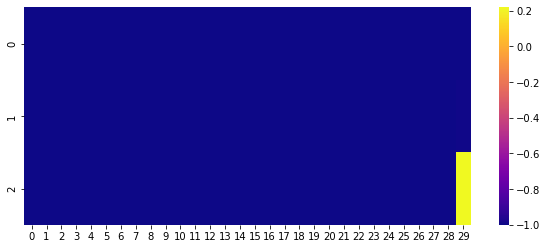

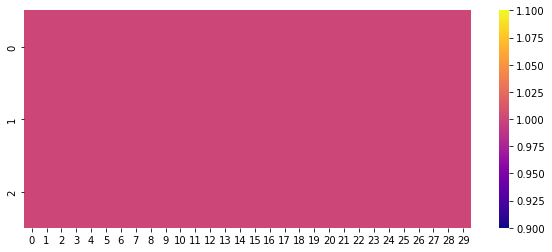

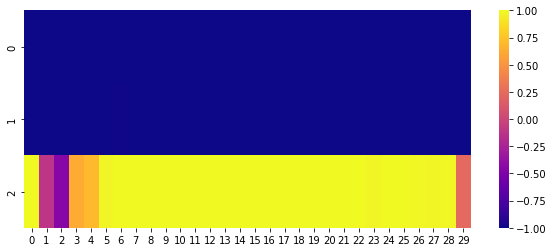

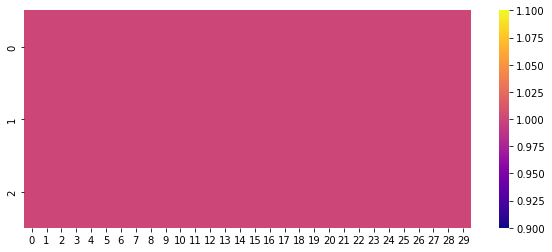

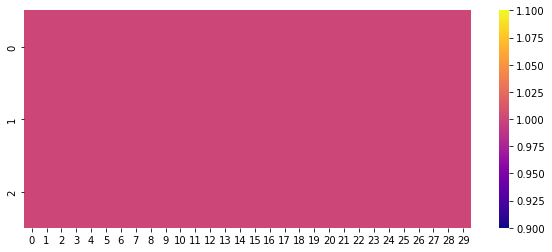

In [84]:
for i in range(10):
    plt.figure(figsize=(10, 4))
    sns.heatmap(act[0, :, :, i], cmap='plasma')

In [59]:
test1000.shape

(60269, 91)

In [60]:
test1400.shape

(60755, 91)

In [61]:
test2400.shape

(61667, 91)

In [62]:
test2700.shape

(61557, 91)